1. 데이터를 로드/간단한 전처리
2. 로지스틱 회귀모델을 사용하여 예측
3. ROC Curve를 통해 모델의 성능확인

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn import metrics
import statsmodels.api as sm
import matplotlib.pyplot as plt
import time

In [5]:
ploan = pd.read_csv('datasets/Personal Loan.csv')
ploan.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [7]:
#사용하지 않는 변수 제거
ploan_processed=ploan.drop(['ID','ZIP Code'], axis=1, inplace=False)

In [8]:
# 회귀모델에서 b0를 위한 상수항 추가
ploan_processed['const']=1.0

In [9]:
#대출여부가 1 또는 0으로 결정되므로 로지스틱 회귀모형이 적합하다.
feature_columns = ploan_processed.columns.difference(["Personal Loan"])
X = ploan_processed[feature_columns]
y = ploan_processed["Personal Loan"]

In [10]:
#학습데이터/평가데이터 분리
train_x, test_x, train_y, test_y = train_test_split(X, y, stratify=y, test_size=0.3, train_size=0.7, random_state=1)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(1750, 12) (750, 12) (1750,) (750,)


In [11]:
# 다변수함수에 뉴턴방법을 적용한 로지스틱 회귀모형
model=sm.Logit(train_y, train_x).fit(method="newton")
model.summary()

Optimization terminated successfully.
         Current function value: 0.135959
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal Loan   No. Observations:                 1750
Model:                          Logit   Df Residuals:                     1738
Method:                           MLE   Df Model:                           11
Date:                Thu, 20 Jan 2022   Pseudo R-squ.:                  0.5881
Time:                        14:49:45   Log-Likelihood:                -237.93
converged:                       True   LL-Null:                       -577.63
Covariance Type:            nonrobust   LLR p-value:                1.397e-138
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Age                   -0.0016      0.101     -0.016      0.987      -0.200       0.196
CCAvg                  0.0954      0.063      1.526      0.127      -0.027       0.218
CD Account             4.3674      0.531      8.226      0.000       3.327       5.408
CreditCard            -1.3552      0.349     -3.881      0.000      -2.040      -0.671
Education              1.4684      0.180      8.162      0.000       1.116       1.821
Experience             0.0165      0.101      0.163      0.870      -0.181       0.214
Family                 0.7160      0.125      5.734      0.000       0.471       0.961
Income                 0.0499      0.004     12.500      0.000       0.042       0.058
Mortgage               0.0006      0.001      0.634      0.526      -0.001       0.002
Online                -0.4918      0.262     -1.880      0.060      -1.005       0.021
Securities Account    -1.4553      0.484     -3.007      0.003      -2.404      -0.507
const                -12.5215      2.730     -4.586      0.000     -17.873      -7.170
======================================================================================
"""

유사결정계수(Pseudo R-squared)는 0.588이다.

In [12]:
#모델적합으로 인해 회귀계수가 출력
print(model.params)
#회귀계수 변환(기존 회귀계수는 log)
print(np.exp(model.params))

Age                   -0.001631
CCAvg                  0.095392
CD Account             4.367360
CreditCard            -1.355179
Education              1.468420
Experience             0.016455
Family                 0.715961
Income                 0.049919
Mortgage               0.000596
Online                -0.491809
Securities Account    -1.455320
const                -12.521527
dtype: float64
Age                    0.998370
CCAvg                  1.100090
CD Account            78.835214
CreditCard             0.257901
Education              4.342370
Experience             1.016592
Family                 2.046153
Income                 1.051186
Mortgage               1.000596
Online                 0.611519
Securities Account     0.233326
const                  0.000004
dtype: float64


Age의 경우 1살이 많을수록 대출할 확률이 0.998배이다. (확률이 낮아진다)

In [13]:
pred_y=model.predict(test_x)
pred_y

1816    0.005733
1195    0.102950
2085    0.005262
406     0.025856
303     0.926229
          ...   
1676    0.184499
680     0.000842
233     0.005965
2373    0.829847
2088    0.003645
Length: 750, dtype: float64

In [14]:
def cut_off(y, threshold) :
    Y = y.copy()
    Y[Y>threshold] = 1
    Y[Y<threshold] = 0
    return Y.astype(int)

pred_Y=cut_off(pred_y,0.5)
pred_Y

1816    0
1195    0
2085    0
406     0
303     1
       ..
1676    0
680     0
233     0
2373    1
2088    0
Length: 750, dtype: int32

In [15]:
cfmat=confusion_matrix(test_y,pred_Y)
print(cfmat)

[[667   6]
 [ 29  48]]


In [16]:
#정확도 계산
def acc(cfmat):
    return (cfmat[0,0] + cfmat[1,1])/(cfmat[0,0] + cfmat[1,1]+cfmat[1,0] + cfmat[0,1])
acc(cfmat)

0.9533333333333334

In [17]:
#임계값에 따른 정확도 확인
threshold=np.arange(0,1,0.1)
table=pd.DataFrame(columns=['ACC'])
for i in threshold :
    pred_Y=cut_off(pred_y, i)
    cfmat=confusion_matrix(test_y,pred_Y)
    table.loc[i]=acc(cfmat)
table.index.name='threshold'
table.columns.name='performance'
table

performance,ACC
threshold,
0.0,0.102667
0.1,0.900000
0.2,0.937333
0.3,0.946667
0.4,0.953333
0.5,0.953333
0.6,0.950667
0.7,0.949333
0.8,0.942667


AUC: 0.9520271704521333


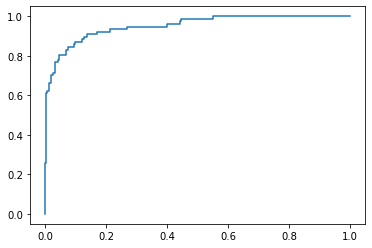

In [18]:
fpr, tpr, thresholds = metrics.roc_curve(test_y,pred_y, pos_label = 1)
# ROC curve
plt.plot(fpr,tpr)

# AUC
auc = np.trapz(tpr,fpr)
print("AUC:",auc)

### 표준화 할 경우

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

In [20]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(train_x, train_y)

LogisticRegression()

In [21]:
#학습세트 정확성 확인
print("학습세트 정확성:",model.score(train_x, train_y))
#평가세트 정확성 확인
print("평가세트 정확성:",model.score(test_x, test_y))

학습세트 정확성: 0.9554285714285714
평가세트 정확성: 0.9546666666666667


In [22]:
print(model.coef_)

[[ 0.04717369  0.18129703  1.05154419 -0.58003624  1.16740131  0.11020206
   0.79306759  2.2328986   0.0621607  -0.22871584 -0.42956106  0.        ]]


In [27]:
ploan[['CD Account','Income']].groupby('CD Account').agg(['mean'])

,Income
,mean
CD Account,
0,72.239761
1,107.615385
